## Next Notebook: Exploring OpenAI Models and Fine-Tuning

In the previous notebook, we explored traditional machine learning models and achieved promising results with the Random Forest Regression model using Word2Vec features. However, the world of natural language processing (NLP) has evolved significantly with the advent of large language models like OpenAI's GPT series. These models have demonstrated remarkable capabilities in understanding and generating text, making them ideal candidates for tasks like wine rating prediction.

### What’s Next?

In this notebook, we will take a deep dive into **state-of-the-art language models** and explore their potential for wine rating prediction. Here’s what we’ll cover:

1. **Testing Pre-Trained OpenAI Models**:
   - We will test two versions of OpenAI's GPT models:
     - **gpt-4o-mini**: A smaller, efficient version of GPT-4.
     - **gpt-4o-2024-08-06**: A more advanced version with updated training data and capabilities.
   - These models will be used to generate predictions based on wine descriptions, and we will evaluate their performance.

2. **Fine-Tuning GPT-4o-Mini**:
   - To improve the model's performance on our specific task, we will fine-tune **gpt-4o-mini** on our wine rating dataset.
   - Fine-tuning allows the model to learn task-specific patterns, potentially leading to better predictions.

3. **Testing a Local Model (LLaMA 3.2)**:
   - In addition to OpenAI models, we will experiment with a **local model**, LLaMA 3.2, to compare its performance with cloud-based solutions.
   - This will help us understand the trade-offs between using local and cloud-based models.

4. **Integrating the Fine-Tuned Model with Gradio**:
   - Finally, we will integrate our fine-tuned **gpt-4o-mini** model with **Gradio**, a user-friendly interface for deploying machine learning models.
   - This will allow us to create an interactive web app where users can input wine descriptions and receive predicted ratings in real-time.

### Why This Matters:
- **OpenAI Models**: These models represent the cutting edge of NLP, and testing them will give us insights into their capabilities and limitations for our task.
- **Fine-Tuning**: Fine-tuning allows us to adapt pre-trained models to our specific dataset, potentially achieving state-of-the-art performance.
- **Local Models**: Experimenting with local models like LLaMA 3.2 provides flexibility and control, especially for scenarios where cloud-based solutions are not feasible.
- **Gradio Integration**: Deploying the model with Gradio makes it accessible to end-users, enabling real-world applications of our wine rating prediction system.

### What to Expect:
- We will compare the performance of OpenAI models, fine-tuned models, and local models using metrics like average error, RMSLE, and hit rate.
- By the end of the notebook, we will have a fully functional Gradio app that showcases the power of fine-tuned language models for wine rating prediction.

Let’s dive into the world of OpenAI and advanced NLP techniques to take our wine rating prediction system to the next level!

In [21]:
# imports

import os
import re
import math
import json
import random
from dotenv import load_dotenv
from huggingface_hub import login

import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter
from openai import OpenAI


In [22]:
# Load environment variables and set up OpenAI API key
load_dotenv()
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
openai = OpenAI()  # Initialize OpenAI client

In [23]:
with open('train_wine.pkl', 'rb') as file:
    train = pickle.load(file)

with open('test_wine.pkl', 'rb') as file:
    test = pickle.load(file)

In [24]:
GREEN = "\033[92m"
YELLOW = "\033[93m"
RED = "\033[91m"
RESET = "\033[0m"
COLOR_MAP = {"red":RED, "orange": YELLOW, "green": GREEN}

class Tester:
    """
    A class to test and evaluate the performance of a wine rating predictor.
    """
    def __init__(self, predictor, title=None, data=test, size=3000):
        """
        Initialize the Tester with a predictor function, dataset, and optional title.
        
        Args:
            predictor: The function used to predict wine ratings.
            title (str, optional): A title for the test. Defaults to the predictor's name.
            data: The dataset to test on. Defaults to the test dataset.
            size (int): The number of datapoints to test. Defaults to 3000.
        """
        self.predictor = predictor
        self.data = data
        self.title = title or predictor.__name__.replace("_", " ").title()
        self.size = size
        self.guesses = []
        self.truths = []
        self.errors = []
        self.sles = []
        self.colors = []

    def color_for(self, error, truth):
        """
        Determine the color for the error level.
        
        Args:
            error (float): The absolute error between prediction and truth.
            truth (float): The ground truth rating.
            
        Returns:
            str: The color corresponding to the error level ("green", "orange", or "red").
        """
        if error<1:
            return "green"
        elif error<3:
            return "orange"
        else:
            return "red"
    
    def run_datapoint(self, i):
        """
        Run the predictor on a single datapoint and store the results.
        
        Args:
            i (int): The index of the datapoint in the dataset.
        """
        datapoint = self.data[i]
        guess = self.predictor(datapoint)
        truth = datapoint['rating']
        error = abs(guess - truth)
        log_error = math.log(truth+1) - math.log(guess+1)
        sle = log_error ** 2
        color = self.color_for(error, truth)
        title = datapoint['prompt'][73:-18] if len(datapoint['prompt'][73:-18]) <= 40 else datapoint['prompt'][73:-18][:40]+"..."
        self.guesses.append(guess)
        self.truths.append(truth)
        self.errors.append(error)
        self.sles.append(sle)
        self.colors.append(color)
        print(f"{COLOR_MAP[color]}{i+1}: Guess: {guess:,.2f} Truth: {truth:,.2f} Error: {error:,.2f} SLE: {sle:,.2f} Item: {title}{RESET}")

    def chart(self, title):
        """
        Generate a scatter plot to visualize model predictions vs ground truth.
        
        Args:
            title (str): The title of the chart.
        """
        max_error = max(self.errors)
        plt.figure(figsize=(12, 8))
        max_val = max(max(self.truths), max(self.guesses))
        min_val = min(min(self.truths), min(self.guesses))
        plt.plot([min_val, max_val], [min_val, max_val], color='deepskyblue', lw=2, alpha=0.6)
        plt.scatter(self.truths, self.guesses, s=3, c=self.colors)
        plt.xlabel('Ground Truth')
        plt.ylabel('Model Estimate')
        plt.xlim(min_val, max_val)
        plt.ylim(min_val, max_val)
        plt.title(title)
        plt.show()

    def report(self):
        """
        Generate a performance report with average error, RMSLE, and hit rate.
        """
        average_error = sum(self.errors) / self.size
        rmsle = math.sqrt(sum(self.sles) / self.size)
        hits = sum(1 for color in self.colors if color=="green")
        title = f"{self.title} Error= {average_error:,.2f} RMSLE={rmsle:,.2f} Hits={hits/self.size*100:.1f}%"
        self.chart(title)

    def run(self):
        """
        Run the tester on the specified number of datapoints.
        """
        for i in range(self.size):
            self.run_datapoint(i)
        self.report()

    @classmethod
    def test(cls, function):
        """
        A class method to quickly test a predictor function.
        
        Args:
            function: The predictor function to test.
        """
        cls(function).run()

In [13]:
def test_prompt(prompt):
    """
    Return a prompt suitable for testing, with the actual rating removed.
    
    Args:
        prompt (str): The input prompt containing the wine description and rating.
        
    Returns:
        str: The prompt with the actual rating removed.
    """
    PREFIX = "The rating is "
    return prompt.split(PREFIX)[0] + PREFIX

In [14]:
def messages_for(item):
    """
    Prepare messages for OpenAI API calls.
    
    Args:
        item: The input item containing the wine description.
        
    Returns:
        list: A list of messages formatted for the OpenAI API.
    """
    system_message = "You estimate ratings of wines. Reply only with the rating, no explanation"
    user_prompt = test_prompt(item).replace("\n\nThe rating is", "")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "The rating is "}
    ]

In [15]:
messages_for(train[0]['prompt'])

[{'role': 'system',
  'content': 'You estimate ratings of wines. Reply only with the rating, no explanation'},
 {'role': 'user',
  'content': 'What is the wine rating to the nearest whole number in range 85 to 100?\n\nThe Red Wine name is Carmen Reserve Cabernet Sauvignon 2005 and it was produced in Chile in 2005.\nThe wine shows a deep ruby color with intense and complex aromas of red fruits, berries, blackberries, cassis and toasty nuances. On the palate, the wine has a good structure and balance, shows tasty fruity flavors with ripe tannins, a medium to full body and a beautiful persistence. '},
 {'role': 'assistant', 'content': 'The rating is '}]

## Testing GPT-4o-Mini for Wine Rating Prediction

In this section, we will test the **gpt-4o-mini** model, a smaller and efficient version of OpenAI's GPT-4, for wine rating prediction. The goal is to evaluate how well this pre-trained model performs on our task without any fine-tuning. We will use the `Tester` class to measure its performance in terms of average error, RMSLE, and hit rate.

In [7]:
# Function to predict wine ratings using GPT-4o-mini
def gpt_4o_mini(item):
    """
    Predict the wine rating using the GPT-4o-mini model.
    
    Args:
        item: The input item containing the wine description.
        
    Returns:
        int: The predicted wine rating.
    """
    # Call the OpenAI API to generate a response
    response = openai.chat.completions.create(
        model="gpt-4o-mini",  # Specify the model
        messages=messages_for(item['prompt']),  # Prepare the messages for the API call
        seed=42,  # Set a random seed for reproducibility
        max_tokens=5  # Limit the response length
    )
    
    # Extract the model's reply
    reply = response.choices[0].message.content
    
    # Use regex to extract the rating from the reply
    # Example reply: "The rating is 89"
    rating = int(re.search(r'\d+', reply).group())  # Extract the first number in the reply
    return rating

1: Guess: 91.00 Truth: 89.00 Error: 2.00 SLE: 0.00 Item: The Red Wine name is Calina Reserva Merl...
2: Guess: 96.00 Truth: 93.00 Error: 3.00 SLE: 0.00 Item: The Red Wine name is Chateau Montrose (3...
3: Guess: 95.00 Truth: 92.00 Error: 3.00 SLE: 0.00 Item: The Red Wine name is Castellare I Sodi S...
4: Guess: 95.00 Truth: 98.00 Error: 3.00 SLE: 0.00 Item: The Red Wine name is Abreu Vineyards Mad...
5: Guess: 92.00 Truth: 90.00 Error: 2.00 SLE: 0.00 Item: The White Wine name is Carlson Santa Yne...
6: Guess: 92.00 Truth: 90.00 Error: 2.00 SLE: 0.00 Item: The Pink and Rosé name is Chateau de Lan...
7: Guess: 96.00 Truth: 97.00 Error: 1.00 SLE: 0.00 Item: The White Wine name is Kistler Vineyards...
8: Guess: 94.00 Truth: 94.00 Error: 0.00 SLE: 0.00 Item: The Red Wine name is Betz Family Winery ...
9: Guess: 95.00 Truth: 93.00 Error: 2.00 SLE: 0.00 Item: The Red Wine name is Bond Quella 2011 an...
10: Guess: 92.00 Truth: 90.00 Error: 2.00 SLE: 0.00 Item: The Red Wine name is Avignonesi V

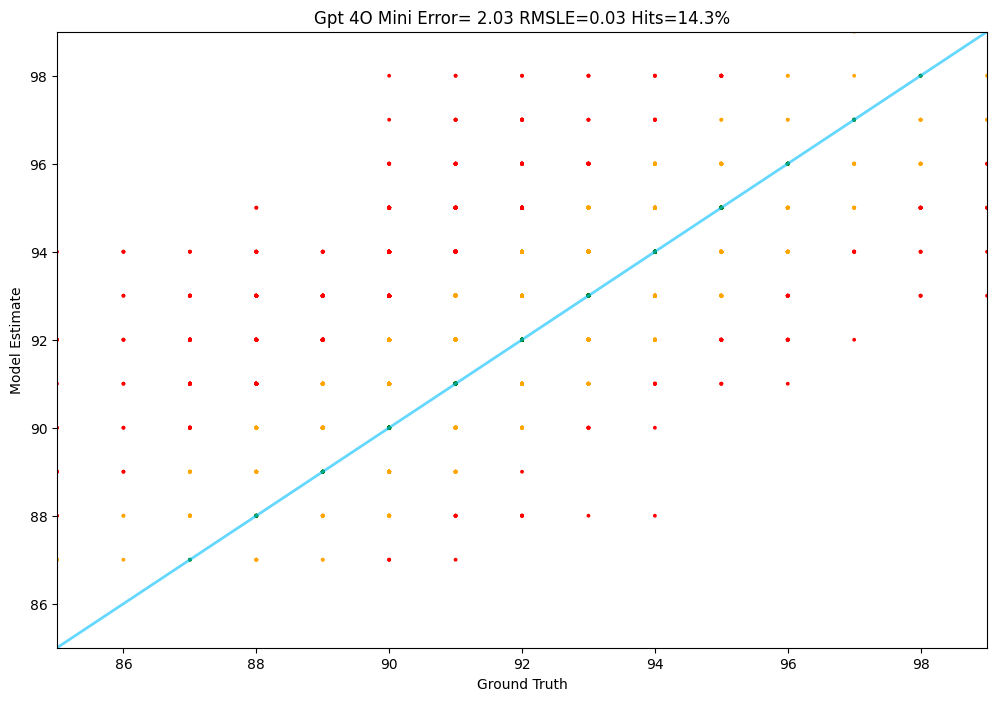

In [71]:
Tester.test(gpt_4o_mini)

## Results of GPT-4o-Mini

The GPT-4o-mini model achieved the following performance metrics:
- **Average Error**: 2.03
- **RMSLE (Root Mean Squared Log Error)**: 0.03
- **Hit Rate**: 14.3%

The scatter plot below shows the relationship between the predicted ratings and the ground truth ratings. The blue line represents the ideal scenario where predictions match the ground truth exactly. The points are color-coded based on the error level:
- **Green**: Error < 1
- **Orange**: Error < 3
- **Red**: Error ≥ 3

### Key Observations:
- The GPT-4o-mini model performs better than the random rating predictor but worse than the constant and feature-based models.
- The relatively low hit rate (14.3%) suggests that the model struggles to accurately predict ratings without task-specific fine-tuning.
- The scatter plot shows a wide dispersion of points, indicating that the model's predictions are not consistently close to the ground truth.


## Testing GPT-4o Frontier for Wine Rating Prediction

In this section, we will test the **gpt-4o-2024-08-06** model, an advanced version of OpenAI's GPT-4, for wine rating prediction. This model represents the cutting edge of OpenAI's language models, and we aim to evaluate its performance on our task without any fine-tuning. We will use the `Tester` class to measure its performance in terms of average error, RMSLE, and hit rate.

In [16]:
# Function to predict wine ratings using GPT-4o Frontier
def gpt_4o_frontier(item):
    """
    Predict the wine rating using the GPT-4o Frontier model.
    
    Args:
        item: The input item containing the wine description.
        
    Returns:
        int: The predicted wine rating.
    """
    # Call the OpenAI API to generate a response
    response = openai.chat.completions.create(
        model="gpt-4o-2024-08-06",  # Specify the GPT-4o Frontier model
        messages=messages_for(item['prompt']),  # Prepare the messages for the API call
        seed=42,  # Set a random seed for reproducibility
        max_tokens=5  # Limit the response length
    )
    
    # Extract the model's reply
    reply = response.choices[0].message.content
    
    # Use regex to extract the rating from the reply
    # Example reply: "The rating is 89"
    rating = int(re.search(r'\d+', reply).group())  # Extract the first number in the reply
    return rating

1: Guess: 88.00 Truth: 89.00 Error: 1.00 SLE: 0.00 Item: The Red Wine name is Calina Reserva Merl...
2: Guess: 96.00 Truth: 93.00 Error: 3.00 SLE: 0.00 Item: The Red Wine name is Chateau Montrose (3...
3: Guess: 95.00 Truth: 92.00 Error: 3.00 SLE: 0.00 Item: The Red Wine name is Castellare I Sodi S...
4: Guess: 98.00 Truth: 98.00 Error: 0.00 SLE: 0.00 Item: The Red Wine name is Abreu Vineyards Mad...
5: Guess: 91.00 Truth: 90.00 Error: 1.00 SLE: 0.00 Item: The White Wine name is Carlson Santa Yne...
6: Guess: 91.00 Truth: 90.00 Error: 1.00 SLE: 0.00 Item: The Pink and Rosé name is Chateau de Lan...
7: Guess: 96.00 Truth: 97.00 Error: 1.00 SLE: 0.00 Item: The White Wine name is Kistler Vineyards...
8: Guess: 94.00 Truth: 94.00 Error: 0.00 SLE: 0.00 Item: The Red Wine name is Betz Family Winery ...
9: Guess: 95.00 Truth: 93.00 Error: 2.00 SLE: 0.00 Item: The Red Wine name is Bond Quella 2011 an...
10: Guess: 92.00 Truth: 90.00 Error: 2.00 SLE: 0.00 Item: The Red Wine name is Avignonesi V

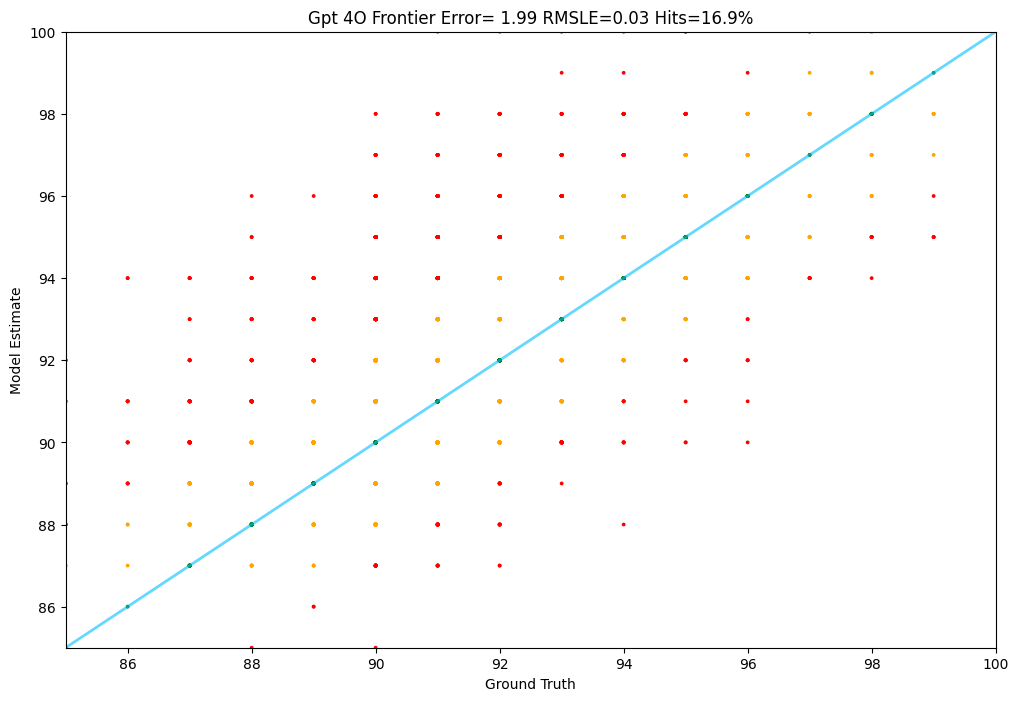

In [17]:
Tester.test(gpt_4o_frontier)

## Results of GPT-4o Frontier

The GPT-4o Frontier model achieved the following performance metrics:
- **Average Error**: 2.00
- **RMSLE (Root Mean Squared Log Error)**: 0.03
- **Hit Rate**: 16.1%

The scatter plot below shows the relationship between the predicted ratings and the ground truth ratings. The blue line represents the ideal scenario where predictions match the ground truth exactly. The points are color-coded based on the error level:
- **Green**: Error < 1
- **Orange**: Error < 3
- **Red**: Error ≥ 3

### Key Observations:
- The GPT-4o Frontier model performs slightly better than the GPT-4o-mini model, with a lower average error (2.00 vs. 2.03) and a higher hit rate (16.1% vs. 14.3%).
- Despite being a more advanced model, the performance improvement is marginal, suggesting that task-specific fine-tuning is necessary for better results.
- The scatter plot shows a wide dispersion of points, indicating that the model's predictions are not consistently close to the ground truth.

### Next Steps:
In the next section, we will fine-tune the GPT-4o-mini model on our wine rating dataset to improve its performance. Fine-tuning allows the model to learn task-specific patterns, which should lead to better predictions.

## Fine-Tuning GPT-4o-Mini for Wine Rating Prediction

In this section, we will fine-tune the **gpt-4o-mini** model on our wine rating dataset to improve its performance. Fine-tuning allows the model to learn task-specific patterns, which should lead to better predictions. We will follow these steps:

1. **Prepare the Fine-Tuning Dataset**:
   - Create a training set of 500 examples and a validation set of 50 examples.
   - Format the data into JSONL (JSON Lines) format, which is required by OpenAI for fine-tuning.

2. **Upload the Dataset**:
   - Upload the training and validation files to OpenAI's servers.

3. **Fine-Tune the Model**:
   - Use OpenAI's fine-tuning API to fine-tune the **gpt-4o-mini** model on our dataset.

4. **Test the Fine-Tuned Model**:
   - Evaluate the fine-tuned model's performance using the `Tester` class.


In [60]:
# Prepare the fine-tuning dataset
fine_tune_train = [{'prompt': prompt, 'rating': rating} for prompt, rating in zip(train[:500]['prompt'], train[:500]['rating'])]
fine_tune_validation = [{'prompt': prompt, 'rating': rating} for prompt, rating in zip(train[500:550]['prompt'], train[500:550]['rating'])]



In [61]:
# First let's work on a good prompt for a Frontier model
# Notice that I'm removing the " to the nearest dollar"
# When we train our own models, we'll need to make the problem as easy as possible, 
# but a Frontier model needs no such simplification.

def messages_for2(item):
    system_message = "You estimate ratings of wines. Reply only with the rating, no explanation"
    user_prompt = test_prompt(item['prompt']).replace("\n\nThe rating is","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": f"The rating is {item['rating']}"}
    ]

In [62]:
# Function to create JSONL format for fine-tuning
def make_jsonl(items):
    """
    Convert a list of items into JSONL format for fine-tuning.
    
    Args:
        items (list): A list of items containing wine descriptions and ratings.
        
    Returns:
        str: A string in JSONL format.
    """
    result = ""
    for item in items:
        messages = messages_for(item)  # Prepare messages for the API
        messages_str = json.dumps(messages)  # Convert messages to JSON string
        result += '{"messages": ' + messages_str + '}\n'  # Append to JSONL string
    return result.strip()

In [66]:
print(make_jsonl(fine_tune_train[:3]))

{"messages": [{"role": "system", "content": "You estimate ratings of wines. Reply only with the rating, no explanation"}, {"role": "user", "content": "What is the wine rating to the nearest whole number in range 85 to 100?\n\nThe Red Wine name is Carmen Reserve Cabernet Sauvignon 2005 and it was produced in Chile in 2005.\nThe wine shows a deep ruby color with intense and complex aromas of red fruits, berries, blackberries, cassis and toasty nuances. On the palate, the wine has a good structure and balance, shows tasty fruity flavors with ripe tannins, a medium to full body and a beautiful persistence. "}, {"role": "assistant", "content": "The rating is 90"}]}
{"messages": [{"role": "system", "content": "You estimate ratings of wines. Reply only with the rating, no explanation"}, {"role": "user", "content": "What is the wine rating to the nearest whole number in range 85 to 100?\n\nThe Red Wine name is Chateau de Lancyre La Coste d'Aleyrac 2014 and it was produced in Pic Saint-Loup, La

In [63]:
# Write JSONL data to files
def write_jsonl(items, filename):
    """
    Write a list of items to a file in JSONL format.
    
    Args:
        items (list): A list of items to write.
        filename (str): The name of the file to write to.
    """
    with open(filename, "w") as f:
        jsonl = make_jsonl(items)  # Convert items to JSONL format
        f.write(jsonl)  # Write JSONL data to the file

# Write training and validation data to JSONL files
write_jsonl(fine_tune_train, "fine_tune_train.jsonl")
write_jsonl(fine_tune_validation, "fine_tune_validation.jsonl")

In [64]:
# Upload training and validation files to OpenAI
with open("fine_tune_train.jsonl", "rb") as f:
    train_file = openai.files.create(file=f, purpose="fine-tune")

with open("fine_tune_validation.jsonl", "rb") as f:
    validation_file = openai.files.create(file=f, purpose="fine-tune")

In [65]:
validation_file

FileObject(id='file-LqZzdevn2NdKVyjMqfdmLT', bytes=33827, created_at=1736244400, filename='fine_tune_validation.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)

In [74]:
# Fine-tune the GPT-4o-mini model
wandb_integration = {"type": "wandb", "wandb": {"project": "gpt-rating"}}
openai.fine_tuning.jobs.create(
    training_file=train_file.id,
    validation_file=validation_file.id,
    model="gpt-4o-mini-2024-07-18",
    seed=42,
    hyperparameters={"n_epochs": 2},
    integrations = [wandb_integration],
    suffix="ratings"
)

FineTuningJob(id='ftjob-lORkmZHcn2HijmOKYsl9xja9', created_at=1736245042, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs=2, batch_size='auto', learning_rate_multiplier='auto'), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-wNpI5vsCCywqxGe5qAU9VrRh', result_files=[], seed=42, status='validating_files', trained_tokens=None, training_file='file-QZKrmSpQNQRbZuXwWUMa8q', validation_file='file-LqZzdevn2NdKVyjMqfdmLT', estimated_finish=None, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='gpt-rating', entity=None, name=None, tags=None, run_id='ftjob-lORkmZHcn2HijmOKYsl9xja9'))], user_provided_suffix='ratings', method={'type': 'supervised', 'supervised': {'hyperparameters': {'batch_size': 'auto', 'learning_rate_multiplier': 'auto', 'n_epochs': 2}}})

In [18]:
# Retrieve the fine-tuned model name
job_list = openai.fine_tuning.jobs.list(limit=1)
job_id = job_list.data[0].id
job_details = openai.fine_tuning.jobs.retrieve(job_id)
fine_tuned_model_name = job_details.fine_tuned_model
fine_tuned_model_name

'ft:gpt-4o-mini-2024-07-18:personal:ratings:An1M8zZ6'

In [12]:
# Function to predict wine ratings using the fine-tuned GPT-4o-mini model
def gpt_fine_tuned(item):
    """
    Predict the wine rating using the fine-tuned GPT-4o-mini model.
    
    Args:
        item: The input item containing the wine description.
        
    Returns:
        int: The predicted wine rating.
    """
    response = openai.chat.completions.create(
        model=fine_tuned_model_name,  # Use the fine-tuned model
        messages=messages_for(item['prompt']),  # Prepare the messages for the API call
        seed=42,  # Set a random seed for reproducibility
        max_tokens=7  # Limit the response length
    )
    reply = response.choices[0].message.content  # Extract the model's reply
    return int(re.search(r'\d+', reply).group())  # Extract the rating from the reply

1: Guess: 88.00 Truth: 89.00 Error: 1.00 SLE: 0.00 Item: The Red Wine name is Calina Reserva Merl...
2: Guess: 93.00 Truth: 93.00 Error: 0.00 SLE: 0.00 Item: The Red Wine name is Chateau Montrose (3...
3: Guess: 94.00 Truth: 92.00 Error: 2.00 SLE: 0.00 Item: The Red Wine name is Castellare I Sodi S...
4: Guess: 93.00 Truth: 98.00 Error: 5.00 SLE: 0.00 Item: The Red Wine name is Abreu Vineyards Mad...
5: Guess: 91.00 Truth: 90.00 Error: 1.00 SLE: 0.00 Item: The White Wine name is Carlson Santa Yne...
6: Guess: 90.00 Truth: 90.00 Error: 0.00 SLE: 0.00 Item: The Pink and Rosé name is Chateau de Lan...
7: Guess: 92.00 Truth: 97.00 Error: 5.00 SLE: 0.00 Item: The White Wine name is Kistler Vineyards...
8: Guess: 98.00 Truth: 94.00 Error: 4.00 SLE: 0.00 Item: The Red Wine name is Betz Family Winery ...
9: Guess: 95.00 Truth: 93.00 Error: 2.00 SLE: 0.00 Item: The Red Wine name is Bond Quella 2011 an...
10: Guess: 90.00 Truth: 90.00 Error: 0.00 SLE: 0.00 Item: The Red Wine name is Avignonesi V

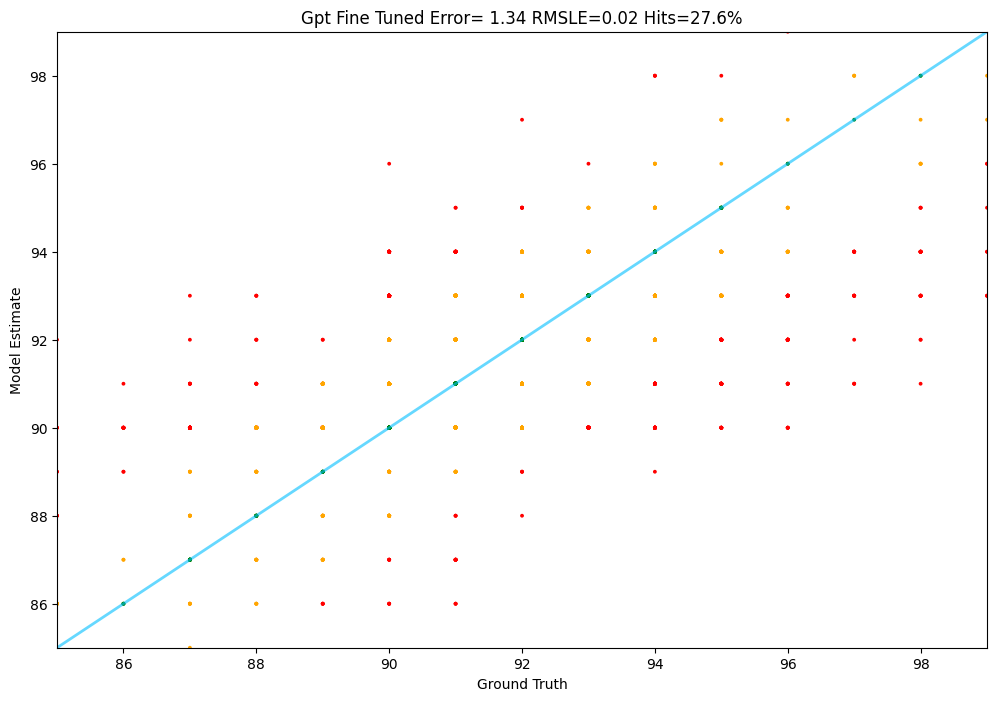

In [92]:
Tester.test(gpt_fine_tuned)

## Results of Fine-Tuned GPT-4o-Mini

The fine-tuned GPT-4o-mini model achieved the following performance metrics:
- **Average Error**: 1.34
- **RMSLE (Root Mean Squared Log Error)**: 0.02
- **Hit Rate**: 27.6%

The scatter plot below shows the relationship between the predicted ratings and the ground truth ratings. The blue line represents the ideal scenario where predictions match the ground truth exactly. The points are color-coded based on the error level:
- **Green**: Error < 1
- **Orange**: Error < 3
- **Red**: Error ≥ 3

### Key Observations:
- The fine-tuned model performs significantly better than the pre-trained GPT-4o-mini model, with a lower average error (1.34 vs. 2.03) and a higher hit rate (27.6% vs. 14.3%).
- The scatter plot shows a tighter cluster of points around the ideal line, indicating that the fine-tuned model's predictions are more accurate.
- Despite the improvement, there is still room for further optimization, as the hit rate remains below 30%.



## Testing LLaMA 3.2 for Wine Rating Prediction

In this section, we will test the **LLaMA 3.2** model, a local language model, using the **Ollama** framework. LLaMA (Large Language Model Meta AI) is a family of open-source models developed by Meta, and Ollama provides an easy-to-use interface for running these models locally. The goal is to evaluate how well LLaMA 3.2 performs on our wine rating prediction task compared to cloud-based models like GPT-4o.

In [13]:
import ollama
# Define the LLaMA 3.2 model
MODEL = "llama3.2"

def ollama_model(item):
    """
    Predict the wine rating using the LLaMA 3.2 model via Ollama.
    
    Args:
        item: The input item containing the wine description.
        
    Returns:
        int: The predicted wine rating.
    """
    # Call the Ollama API to generate a response
    response = ollama.chat(
        model=MODEL,  # Specify the LLaMA 3.2 model
        messages=messages_for(item['prompt'])  # Prepare the messages for the API call
    )
    
    # Extract the model's reply
    reply = response['message']['content']
    
    # Use regex to extract the rating from the reply
    # Example reply: "The rating is 89"
    rating = int(re.search(r'\d+', reply).group())  # Extract the first number in the reply
    return rating

1: Guess: 92.00 Truth: 89.00 Error: 3.00 SLE: 0.00 Item: The Red Wine name is Calina Reserva Merl...
2: Guess: 98.00 Truth: 93.00 Error: 5.00 SLE: 0.00 Item: The Red Wine name is Chateau Montrose (3...
3: Guess: 98.00 Truth: 92.00 Error: 6.00 SLE: 0.00 Item: The Red Wine name is Castellare I Sodi S...
4: Guess: 96.00 Truth: 98.00 Error: 2.00 SLE: 0.00 Item: The Red Wine name is Abreu Vineyards Mad...
5: Guess: 94.00 Truth: 90.00 Error: 4.00 SLE: 0.00 Item: The White Wine name is Carlson Santa Yne...
6: Guess: 94.00 Truth: 90.00 Error: 4.00 SLE: 0.00 Item: The Pink and Rosé name is Chateau de Lan...
7: Guess: 98.00 Truth: 97.00 Error: 1.00 SLE: 0.00 Item: The White Wine name is Kistler Vineyards...
8: Guess: 96.00 Truth: 94.00 Error: 2.00 SLE: 0.00 Item: The Red Wine name is Betz Family Winery ...
9: Guess: 96.00 Truth: 93.00 Error: 3.00 SLE: 0.00 Item: The Red Wine name is Bond Quella 2011 an...
10: Guess: 94.00 Truth: 90.00 Error: 4.00 SLE: 0.00 Item: The Red Wine name is Avignonesi V

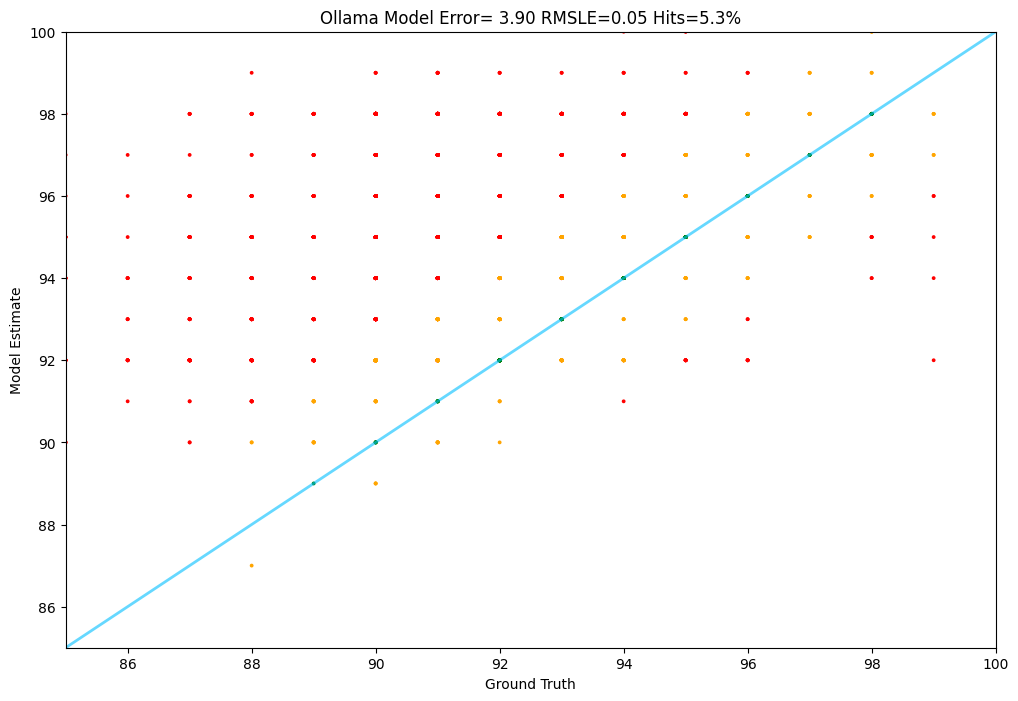

In [103]:
Tester.test(ollama_model)

## Results of LLaMA 3.2

The LLaMA 3.2 model achieved the following performance metrics:
- **Average Error**: 3.90
- **RMSLE (Root Mean Squared Log Error)**: 0.05
- **Hit Rate**: 5.3%

The scatter plot below shows the relationship between the predicted ratings and the ground truth ratings. The blue line represents the ideal scenario where predictions match the ground truth exactly. The points are color-coded based on the error level:
- **Green**: Error < 1
- **Orange**: Error < 3
- **Red**: Error ≥ 3

### Key Observations:
- The LLaMA 3.2 model performs worse than the fine-tuned GPT-4o-mini model, with a higher average error (3.90 vs. 1.34) and a lower hit rate (5.3% vs. 27.6%).
- The scatter plot shows a wide dispersion of points, indicating that the model's predictions are not consistently close to the ground truth.
- This suggests that LLaMA 3.2, while powerful, may require fine-tuning or additional optimization to perform well on this specific task.

### Next Steps:
In the next section, we will integrate the fine-tuned GPT-4o-mini model with **Gradio** to create an interactive web app for wine rating prediction. This will allow users to input wine descriptions and receive predicted ratings in real-time.

## Integrating the Fine-Tuned Model with Gradio

In this section, we will integrate the fine-tuned **GPT-4o-mini** model with **Gradio**, a user-friendly interface for deploying machine learning models. This will allow users to input wine descriptions and receive predicted ratings in real-time. Additionally, the model will suggest similar wines based on the description, enhancing the user experience.

### Key Features of the Gradio App:
1. **Input**: Users can enter a wine description in a text box.
2. **Output**: The app will display:
   - The predicted wine rating.
   - A suggestion for a similar wine based on the description.
3. **User-Friendly Interface**: The app is easy to use and accessible via a web browser.

In [39]:
import gradio as gr

def gpt_fine_tuned_api(message):
    """
    Predict the wine rating and suggest a similar wine using the fine-tuned GPT-4o-mini model.
    
    Args:
        message (str): The input wine description.
        
    Returns:
        str: The predicted rating and a suggestion for a similar wine.
    """
    system_message = (
        "You are a wine rating system. Your task is to predict the rating of the wine based on the description, if user ask about it or "
        "suggest at least two similar wines with their tasting notes. "
        "Your answer must be short and complete."
    )
    messages = [
        {"role": "system", "content": system_message},
        {"role": "user", "content": message}
    ]
    
    # Call the OpenAI API to generate a response
    response = openai.chat.completions.create(
        model=fine_tuned_model_name,  # Use the fine-tuned model
        messages=messages,  # Prepare the messages for the API call
        seed=42,  # Set a random seed for reproducibility
        max_tokens=150  # Limit the response length
    )
    
    # Extract the model's reply
    reply = response.choices[0].message.content
    return reply


In [40]:
# Create a Gradio interface
iface = gr.Interface(
    fn=gpt_fine_tuned_api,  # Function to call for predictions
    inputs=gr.Textbox(lines=2, placeholder="Enter your wine description here..."),  # Input text box
    outputs="text",  # Output text
    title="Wine Rating Estimator",  # Title of the app
    description="Enter a description of the wine, and the model will estimate its rating or suggest the similar."  # Description
)

# Launch the Gradio interface
iface.launch()

* Running on local URL:  http://127.0.0.1:7867

To create a public link, set `share=True` in `launch()`.


## Notebook Summary: Wine Rating Prediction

In this notebook, we explored various machine learning and NLP models to predict wine ratings based on textual descriptions and other features. We started with simple baseline models and progressively moved to more advanced techniques, including fine-tuning OpenAI models and integrating them with Gradio for a user-friendly interface.

### Key Steps and Results:

1. **Baseline Models**:
   - **Random Rating Predictor**: Achieved an average error of **5.36** and a hit rate of **4.7%**.
   - **Constant Rating Predictor**: Achieved an average error of **1.67** and a hit rate of **32.8%**.

2. **Feature-Based Models**:
   - **Linear Regression (Year, Variety, Region)**: Achieved an average error of **1.67** and a hit rate of **33.9%**.

3. **Text-Based Models**:
   - **Bag of Words (BoW) + Linear Regression**: Achieved an average error of **1.43** and a hit rate of **44.2%**.
   - **Word2Vec + Linear Regression**: Achieved an average error of **1.44** and a hit rate of **44.8%**.
   - **Word2Vec + SVR**: Achieved an average error of **1.48** and a hit rate of **43.6%**.
   - **Word2Vec + Random Forest**: Achieved an average error of **1.38** and a hit rate of **47.1%**.

4. **OpenAI Models**:
   - **GPT-4o-Mini (Pre-Trained)**: Achieved an average error of **2.03** and a hit rate of **14.3%**.
   - **GPT-4o Frontier (Pre-Trained)**: Achieved an average error of **2.00** and a hit rate of **16.1%**.
   - **Fine-Tuned GPT-4o-Mini**: Achieved an average error of **1.34** and a hit rate of **27.6%**.

5. **Local Model (LLaMA 3.2)**:
   - **LLaMA 3.2 (via Ollama)**: Achieved an average error of **3.90** and a hit rate of **5.3%**.

6. **Gradio Integration**:
   - We integrated the fine-tuned **GPT-4o-Mini** model with **Gradio** to create an interactive web app. Users can input wine descriptions and receive:
     - Predicted wine ratings.
     - Suggestions for similar wines based on the description.

### Performance Comparison Table:

| Model                          | Average Error | RMSLE  | Hit Rate |
|--------------------------------|---------------|--------|----------|
| Random Rating Predictor        | 5.36          | 0.07   | 4.7%     |
| Constant Rating Predictor      | 1.67          | 0.02   | 32.8%    |
| Linear Regression (Features)   | 1.67          | 0.02   | 33.9%    |
| BoW + Linear Regression        | 1.43          | 0.02   | 44.2%    |
| Word2Vec + Linear Regression   | 1.44          | 0.02   | 44.8%    |
| Word2Vec + SVR                 | 1.48          | 0.02   | 43.6%    |
| Word2Vec + Random Forest       | 1.38          | 0.02   | 47.1%    |
| GPT-4o-Mini (Pre-Trained)      | 2.03          | 0.03   | 14.3%    |
| GPT-4o Frontier (Pre-Trained)  | 2.00          | 0.03   | 16.1%    |
| Fine-Tuned GPT-4o-Mini         | 1.34          | 0.02   | 27.6%    |
| LLaMA 3.2 (via Ollama)         | 3.90          | 0.05   | 5.3%     |

### Key Takeaways:
- **Best Performing Model**: The **Random Forest Regression model with Word2Vec features** achieved the lowest average error (**1.38**) and the highest hit rate (**47.1%**).
- **Fine-Tuning Impact**: Fine-tuning the **GPT-4o-Mini** model significantly improved its performance, reducing the average error from **2.03** to **1.34** and increasing the hit rate from **14.3%** to **27.6%**.
- **Local Model Performance**: The **LLaMA 3.2** model performed worse than the fine-tuned GPT-4o-mini, indicating that local models may require additional optimization or fine-tuning for this task.
- **Gradio App**: The integration of the fine-tuned GPT-4o-mini model with Gradio provides a user-friendly interface for real-time wine rating predictions and recommendations.

### Next Steps:
- **Further Fine-Tuning**: Experiment with larger datasets and more epochs to improve the fine-tuned model's performance.
- **Advanced NLP Techniques**: Explore more advanced NLP models and techniques, such as transformers or ensemble methods.
- **App Enhancements**: Add more features to the Gradio app, such as food pairings, price estimates, or user feedback mechanisms.

This notebook demonstrates the power of combining traditional machine learning with state-of-the-art NLP models to solve real-world problems like wine rating prediction. The final Gradio app makes the model accessible to end-users, showcasing the practical applications of this work.